<a href="https://colab.research.google.com/github/sara-git-hub/footbal_data_engineering/blob/main/footbal_data_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install pyspark -q

In [8]:
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("FootballAnalysis").getOrCreate()

spark.version

'3.5.1'

In [9]:
# Charger le CSV dans un DataFrame
df = spark.read.csv("football-matches.csv", header=True, inferSchema=True)

In [10]:
df.show()

+--------+---+------+----------+------------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|          HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+------------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|        Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|       Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|     Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|     Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|             Ahlen|     Karlsruhe|   1|   3|  A|
|       6| D2|  2009|2010-04-03|      Union Berlin|     Karlsruhe|   1|   1|  D|
|       7| D2|  2009|2009-08-14|         Paderborn|     Karlsruhe|   2|   0|  H|
|       8| D2|  2009|2010-03-08|         Bielefeld|     Karlsruhe|   0|   1|  A|
|       9| D2|  2009|2009-09-26|    Kaiserslautern|     Karlsruhe|   2|   0|  H|
|      10| D2|  2009|2009-11

In [11]:
df = df.select("Match_ID","Div", "Season", "Date","HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR") \
       .withColumnRenamed("FTHG", "HomeTeamGoals") \
       .withColumnRenamed("FTAG", "AwayTeamGoals") \
       .withColumnRenamed("FTR", "FinalResult")

df.show()

+--------+---+------+----------+------------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|      Date|          HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|
+--------+---+------+----------+------------------+--------------+-------------+-------------+-----------+
|       1| D2|  2009|2010-04-04|        Oberhausen|Kaiserslautern|            2|            1|          H|
|       2| D2|  2009|2009-11-01|       Munich 1860|Kaiserslautern|            0|            1|          A|
|       3| D2|  2009|2009-10-04|     Frankfurt FSV|Kaiserslautern|            1|            1|          D|
|       4| D2|  2009|2010-02-21|     Frankfurt FSV|     Karlsruhe|            2|            1|          H|
|       5| D2|  2009|2009-12-06|             Ahlen|     Karlsruhe|            1|            3|          A|
|       6| D2|  2009|2010-04-03|      Union Berlin|     Karlsruhe|            1|            1|          D|
|       7| D2|  2009|2009-08-14|     

In [12]:
#Création de colonnes supplémentaires

df = df.withColumn("HomeTeamWin", F.when(F.col("FinalResult") == "H", 1).otherwise(0)) \
           .withColumn("AwayTeamWin", F.when(F.col("FinalResult") == "A", 1).otherwise(0)) \
           .withColumn("GameTie", F.when(F.col("FinalResult") == "D", 1).otherwise(0))

In [13]:
# Filtrage des données

df_filtered = df.filter((F.col("Div") == "D1") & (F.col("Season").between(2000, 2015)))

df_filtered.show()


+--------+---+------+----------+-------------+----------+-------------+-------------+-----------+-----------+-----------+-------+
|Match_ID|Div|Season|      Date|     HomeTeam|  AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|HomeTeamWin|AwayTeamWin|GameTie|
+--------+---+------+----------+-------------+----------+-------------+-------------+-----------+-----------+-----------+-------+
|      21| D1|  2009|2010-02-06|       Bochum|Leverkusen|            1|            1|          D|          0|          0|      1|
|      22| D1|  2009|2009-11-22|Bayern Munich|Leverkusen|            1|            1|          D|          0|          0|      1|
|      23| D1|  2009|2010-05-08|   M'gladbach|Leverkusen|            1|            1|          D|          0|          0|      1|
|      24| D1|  2009|2009-08-08|        Mainz|Leverkusen|            2|            2|          D|          0|          0|      1|
|      25| D1|  2009|2009-10-17|      Hamburg|Leverkusen|            0|            0|     

In [14]:
#Agrégations avec Group By

df_home_matches = df_filtered.groupBy("Season", "HomeTeam").agg(
    F.sum("HomeTeamWin").alias("TotalHomeWin"),
    F.sum("AwayTeamWin").alias("TotalHomeLoss"),
    F.sum("GameTie").alias("TotalHomeTie"),
    F.sum("HomeTeamGoals").alias("HomeScoredGoals"),
    F.sum("AwayTeamGoals").alias("HomeAgainstGoals")
).withColumnRenamed("HomeTeam", "Team")

df_home_matches.show()

+------+--------------+------------+-------------+------------+---------------+----------------+
|Season|          Team|TotalHomeWin|TotalHomeLoss|TotalHomeTie|HomeScoredGoals|HomeAgainstGoals|
+------+--------------+------------+-------------+------------+---------------+----------------+
|  2005| Bayern Munich|          14|            1|           2|             42|              14|
|  2008|    M'gladbach|           5|            8|           4|             23|              27|
|  2014|      Freiburg|           5|            6|           6|             21|              22|
|  2015|     Wolfsburg|           9|            3|           5|             32|              17|
|  2006|       Cottbus|           6|            6|           5|             21|              22|
|  2015| Ein Frankfurt|           6|            5|           6|             22|              24|
|  2010|      Hannover|          12|            4|           1|             32|              17|
|  2004|    Leverkusen|       

In [15]:
#Agrégations avec Group By

df_away_matches = df_filtered.groupBy("Season", "AwayTeam").agg(
    F.sum("AwayTeamWin").alias("TotalAwayWin"),
    F.sum("HomeTeamWin").alias("TotalAwayLoss"),
    F.sum("GameTie").alias("TotalAwayTie"),
    F.sum("AwayTeamGoals").alias("AwayScoredGoals"),
    F.sum("HomeTeamGoals").alias("AwayAgainstGoals")
).withColumnRenamed("AwayTeam", "Team")

df_home_matches.show()

+------+--------------+------------+-------------+------------+---------------+----------------+
|Season|          Team|TotalHomeWin|TotalHomeLoss|TotalHomeTie|HomeScoredGoals|HomeAgainstGoals|
+------+--------------+------------+-------------+------------+---------------+----------------+
|  2005| Bayern Munich|          14|            1|           2|             42|              14|
|  2008|    M'gladbach|           5|            8|           4|             23|              27|
|  2014|      Freiburg|           5|            6|           6|             21|              22|
|  2015|     Wolfsburg|           9|            3|           5|             32|              17|
|  2006|       Cottbus|           6|            6|           5|             21|              22|
|  2015| Ein Frankfurt|           6|            5|           6|             22|              24|
|  2010|      Hannover|          12|            4|           1|             32|              17|
|  2004|    Leverkusen|       

In [16]:
# Jointure de DataFrames
df_merged = df_home_matches.join(df_away_matches, on=["Season", "Team"], how="full_outer")
df_merged.show()

+------+--------------+------------+-------------+------------+---------------+----------------+------------+-------------+------------+---------------+----------------+
|Season|          Team|TotalHomeWin|TotalHomeLoss|TotalHomeTie|HomeScoredGoals|HomeAgainstGoals|TotalAwayWin|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|
+------+--------------+------------+-------------+------------+---------------+----------------+------------+-------------+------------+---------------+----------------+
|  2000| Bayern Munich|          12|            4|           1|             37|              20|           7|            5|           5|             25|              17|
|  2000|        Bochum|           5|            8|           4|             20|              28|           2|           13|           2|             10|              39|
|  2000|       Cottbus|          10|            6|           1|             27|              20|           2|           13|           2|             1

In [17]:
# Création de nouvelles colonnes synthétiques

df_processed = df_merged.withColumn("GoalsScored",
                                    F.coalesce(F.col("HomeScoredGoals"), F.lit(0)) + F.coalesce(F.col("AwayScoredGoals"), F.lit(0))
                                   ).withColumn("GoalsAgainst",
                                    F.coalesce(F.col("HomeAgainstGoals"), F.lit(0)) + F.coalesce(F.col("AwayAgainstGoals"), F.lit(0))
                                   ).withColumn("Win",
                                    F.coalesce(F.col("TotalHomeWin"), F.lit(0)) + F.coalesce(F.col("TotalAwayWin"), F.lit(0))
                                   ).withColumn("Loss",
                                    F.coalesce(F.col("TotalHomeLoss"), F.lit(0)) + F.coalesce(F.col("TotalAwayLoss"), F.lit(0))
                                   ).withColumn("Tie",
                                    F.coalesce(F.col("TotalHomeTie"), F.lit(0)) + F.coalesce(F.col("TotalAwayTie"), F.lit(0))
                                   ).withColumn("GoalDifferentials",
                                    F.col("GoalsScored") - F.col("GoalsAgainst")
                                   ).withColumn("TotalGames",
                                    F.col("Win") + F.col("Loss") + F.col("Tie")
                                   ).withColumn("WinPercentage",
                                    F.when(F.col("TotalGames") > 0, (F.col("Win") / F.col("TotalGames")) * 100).otherwise(F.lit(0))
                                   ).withColumn("GoalsPerGame",
                                    F.when(F.col("TotalGames") > 0, F.col("GoalsScored") / F.col("TotalGames")).otherwise(F.lit(0))
                                   ).withColumn("GoalsAgainstPerGame",
                                    F.when(F.col("TotalGames") > 0, F.col("GoalsAgainst") / F.col("TotalGames")).otherwise(F.lit(0))
                                   )
df_processed.show()

+------+--------------+------------+-------------+------------+---------------+----------------+------------+-------------+------------+---------------+----------------+-----------+------------+---+----+---+-----------------+----------+------------------+------------------+-------------------+
|Season|          Team|TotalHomeWin|TotalHomeLoss|TotalHomeTie|HomeScoredGoals|HomeAgainstGoals|TotalAwayWin|TotalAwayLoss|TotalAwayTie|AwayScoredGoals|AwayAgainstGoals|GoalsScored|GoalsAgainst|Win|Loss|Tie|GoalDifferentials|TotalGames|     WinPercentage|      GoalsPerGame|GoalsAgainstPerGame|
+------+--------------+------------+-------------+------------+---------------+----------------+------------+-------------+------------+---------------+----------------+-----------+------------+---+----+---+-----------------+----------+------------------+------------------+-------------------+
|  2000| Bayern Munich|          12|            4|           1|             37|              20|           7|      

In [19]:
# Classement par saison (Window functions)

windowSpec = Window.partitionBy("Season").orderBy(F.desc("WinPercentage"), F.desc("GoalDifferentials"))

df_ranked = df_processed.withColumn("TeamPosition", F.rank().over(windowSpec))

df_ranked.select("Season","Team","Win","TotalGames","WinPercentage","GoalDifferentials","TeamPosition").orderBy("Season","TeamPosition").show(20, truncate=False)

+------+--------------+---+----------+------------------+-----------------+------------+
|Season|Team          |Win|TotalGames|WinPercentage     |GoalDifferentials|TeamPosition|
+------+--------------+---+----------+------------------+-----------------+------------+
|2000  |Bayern Munich |19 |34        |55.88235294117647 |25               |1           |
|2000  |Schalke 04    |18 |34        |52.94117647058824 |30               |2           |
|2000  |Hertha        |18 |34        |52.94117647058824 |6                |3           |
|2000  |Leverkusen    |17 |34        |50.0              |14               |4           |
|2000  |Dortmund      |16 |34        |47.05882352941176 |20               |5           |
|2000  |Freiburg      |15 |34        |44.11764705882353 |17               |6           |
|2000  |Werder Bremen |15 |34        |44.11764705882353 |5                |7           |
|2000  |Kaiserslautern|15 |34        |44.11764705882353 |-5               |8           |
|2000  |Wolfsburg    

In [22]:
# Extraction des champions & sauvegarde Parquet
final_cols=["Season","Team","GoalsScored","GoalsAgainst","Win","Loss","Tie",
    "GoalDifferentials","WinPercentage","TotalGames","GoalsPerGame","GoalsAgainstPerGame"]

df_champions = df_ranked.filter(F.col("TeamPosition") == 1).select(*[c for c in final_cols if c in df_ranked.columns] + ["TeamPosition"])

print("Champions par saison (extrait) :")
df_champions.orderBy("Season").show(100, truncate=False)

# Sauvegarder en Parquet local (Colab)
df_ranked.write.mode("overwrite").partitionBy("Season").parquet("football_stats_partitioned")
df_champions.write.mode("overwrite").parquet("football_top_teams")
print("Sauvegardes Parquet : football_stats_partitioned/  et  football_top_teams/")

Champions par saison (extrait) :
+------+-------------+-----------+------------+---+----+---+-----------------+-----------------+----------+------------------+-------------------+------------+
|Season|Team         |GoalsScored|GoalsAgainst|Win|Loss|Tie|GoalDifferentials|WinPercentage    |TotalGames|GoalsPerGame      |GoalsAgainstPerGame|TeamPosition|
+------+-------------+-----------+------------+---+----+---+-----------------+-----------------+----------+------------------+-------------------+------------+
|2000  |Bayern Munich|62         |37          |19 |9   |6  |25               |55.88235294117647|34        |1.8235294117647058|1.088235294117647  |1           |
|2001  |Leverkusen   |77         |38          |21 |7   |6  |39               |61.76470588235294|34        |2.264705882352941 |1.1176470588235294 |1           |
|2002  |Bayern Munich|70         |25          |23 |5   |6  |45               |67.64705882352942|34        |2.0588235294117645|0.7352941176470589 |1           |
|2003  

DataFrame pandas des champions : (16, 13)


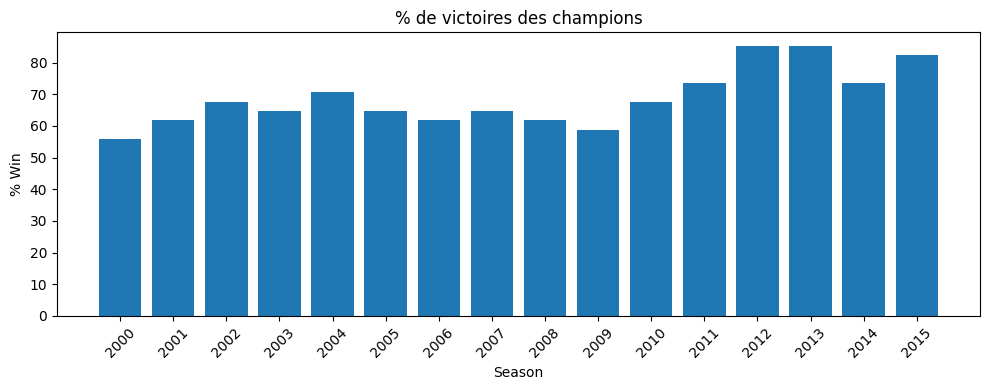

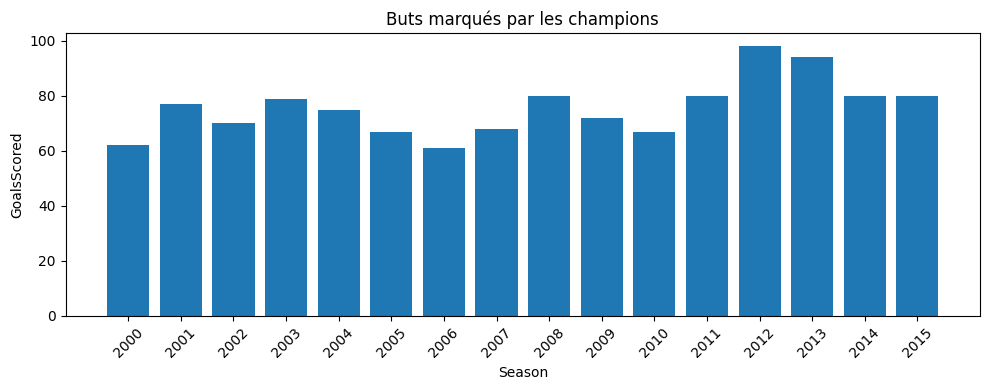

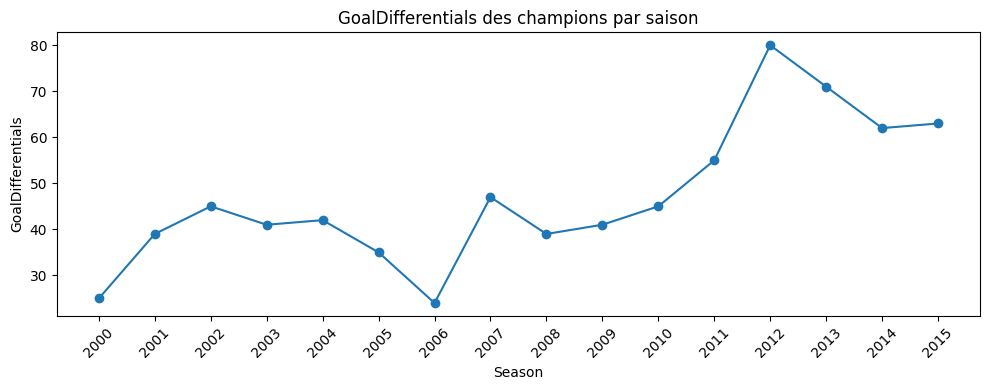

In [23]:
# Visualisation (convert champions en pandas)

champions_pd = df_champions.orderBy("Season").toPandas()
print("DataFrame pandas des champions :", champions_pd.shape)

import matplotlib.pyplot as plt

if champions_pd.shape[0] == 0:
    print("Aucun champion trouvé (df_champions vide). Vérifie le filtrage 'Div' et 'Season'.")
else:
    champions_pd = champions_pd.sort_values("Season")
    # Faire fig 1 : % de victoires
    plt.figure(figsize=(10,4))
    plt.bar(champions_pd["Season"].astype(str), champions_pd["WinPercentage"])
    plt.title("% de victoires des champions")
    plt.xlabel("Season")
    plt.ylabel("% Win")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # fig 2 : buts marqués
    plt.figure(figsize=(10,4))
    plt.bar(champions_pd["Season"].astype(str), champions_pd["GoalsScored"])
    plt.title("Buts marqués par les champions")
    plt.xlabel("Season")
    plt.ylabel("GoalsScored")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # fig 3 : GoalDifferentials
    plt.figure(figsize=(10,4))
    plt.plot(champions_pd["Season"].astype(str), champions_pd["GoalDifferentials"], marker="o")
    plt.title("GoalDifferentials des champions par saison")
    plt.xlabel("Season")
    plt.ylabel("GoalDifferentials")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()